In [77]:
import bionetgen
import numpy as np
import matplotlib.pyplot as plt
import roadrunner as rr

In [78]:
modelName = "Model1"
#modelName = "Model2"
#modelName = "Model3"

model = bionetgen.bngmodel(modelName + ".bngl") 
sim = model.setup_simulator() 
sim.setIntegrator('gillespie')


## Run and Plot Timecourse 

1.0 7e-08
5.0 3.5000000000000004e-07
10.0 7.000000000000001e-07


Text(0, 0.5, 'counts')

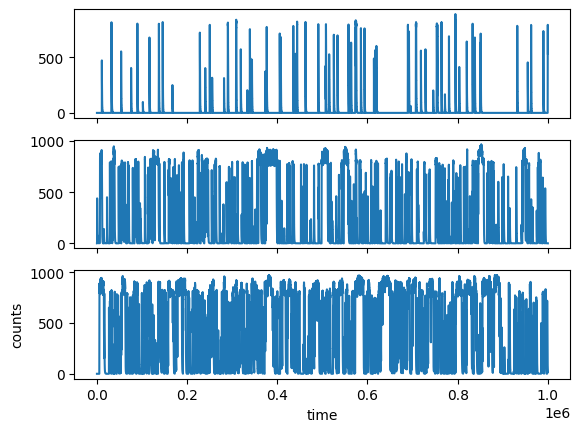

In [79]:

## Run time course trajectories 

snames=['totalRasGTP','totalBoundSOS','TotalRas'] # observables
pval = [1, 5, 10] # MODEL 1 and 3  
#pval = [1, 15, 30] # MODEL 2 

traj=[0]*len(pval) 


# for altering parameters in the model , comment out 
#sim.Kcat2=2.5e-2 #multimodal 

Kon= 7e-8  #processive (Models 1 and 2)
#Kon = 7e-5# nonprocessive (Model 3)


for i, p in enumerate(pval):
    sim.RhoSOS= p
    
    sim.Kon1= p*Kon  # manually update Kon1 and Kon2 values 
    sim.Kon2= p*Kon 
    sim.reset()
    print(sim.RhoSOS,sim.Kon1)
    traj[i]= sim.simulate(0,1000000,1000000)

# plot trajectories
fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True) 
for i in range(len(traj)):
    axes[i].plot(traj[i]['time'],traj[i][snames[0]])
axes[-1].set_xlabel('time')
axes[-1].set_ylabel('counts')
#plt.tight_layout()



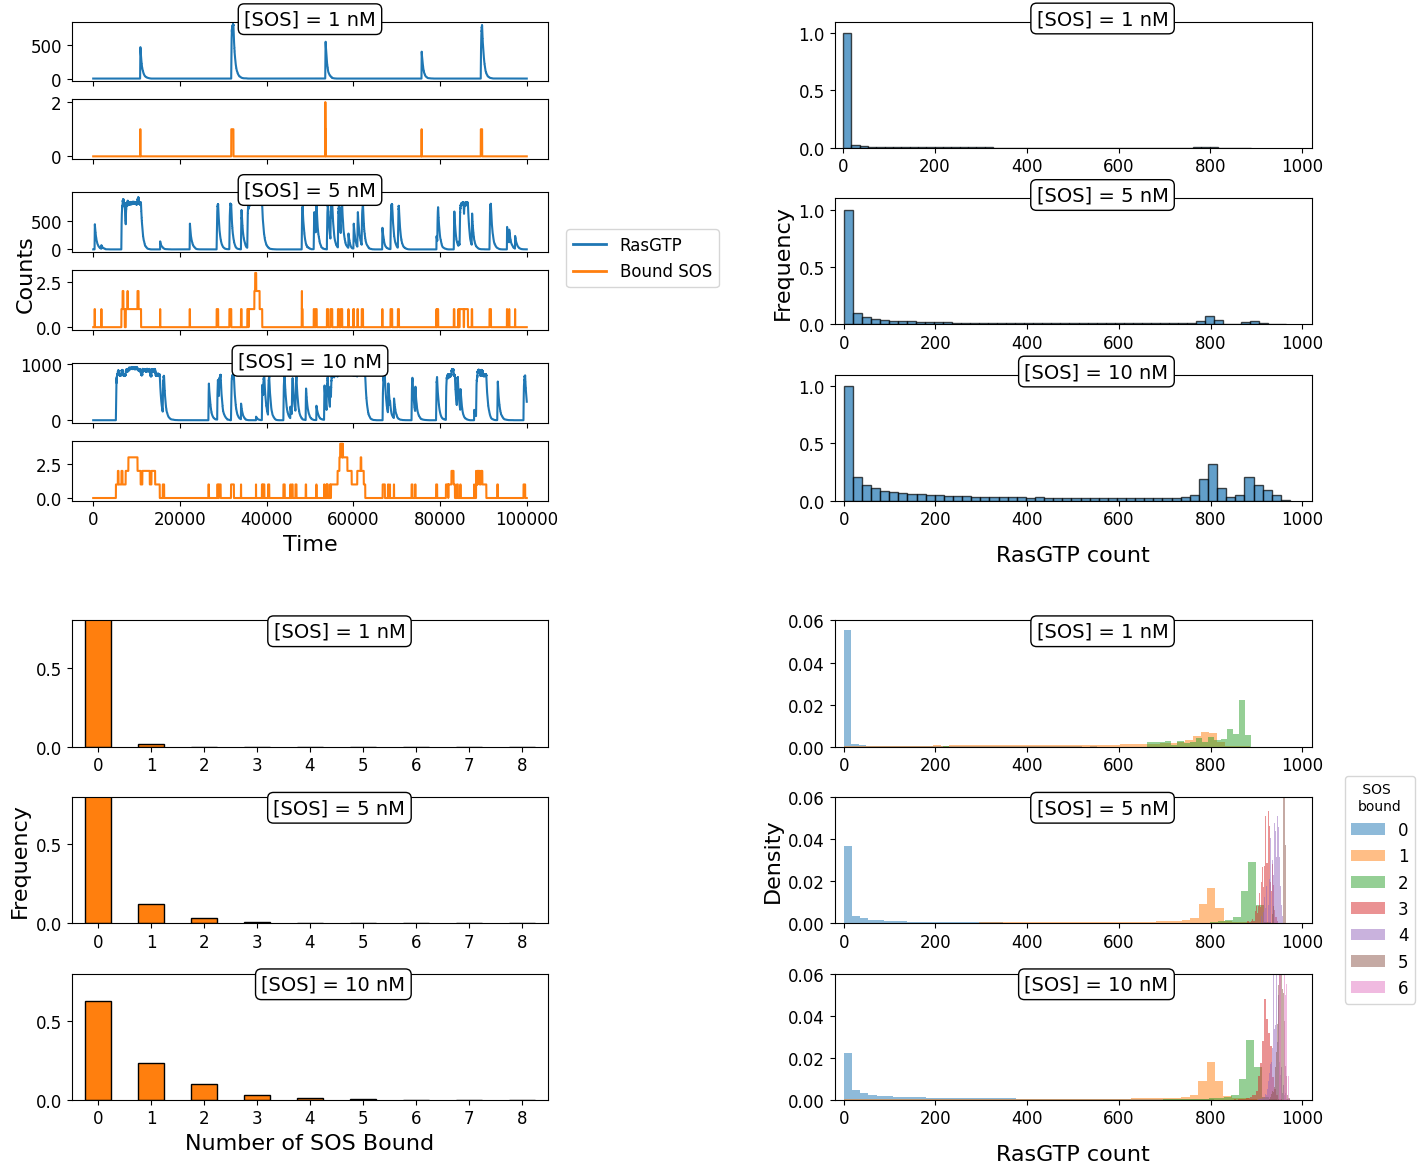

In [81]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D

sos_values = [1, 5, 10] #[1,15,30]
indices = [i for i, val in enumerate(pval) if val in sos_values]
n_groups = len(indices)

fig = plt.figure(figsize=(16, 14))
outer = gridspec.GridSpec(2, 2, figure=fig, wspace=0.6, hspace=0.25)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

#  TIME SERIES 
obs = snames[:2]  
n_obs = len(obs)

subplot_height = 1.76
intragroup_spacing = 0.1
intergroup_spacing = 0.55
height_ratios = []
for _ in range(n_groups):
    for _ in range(n_obs):
        height_ratios.append(subplot_height)
        height_ratios.append(intragroup_spacing)
    height_ratios.pop()
    height_ratios.append(intergroup_spacing)
height_ratios.pop()

innerA = gridspec.GridSpecFromSubplotSpec(len(height_ratios), 1,
                                          subplot_spec=outer[0, 0],
                                          height_ratios=height_ratios)

row_idx = 0
axesA_groups = []  

for group_idx, idx in enumerate(indices):
    traj_i = traj[idx]
    time = traj_i['time']
    mask = time <= 100000

    
    time_trunc = time[mask]
    group_axes = []

    for j, ob in enumerate(obs):
        ax = fig.add_subplot(innerA[row_idx])
        group_axes.append(ax)
        color = color_cycle[j % len(color_cycle)]

        
        pretty = "RasGTP" if "rasgtp" in ob.lower() else "Bound SOS"
        ax.plot(time_trunc, traj_i[ob][mask], color=color)
        ax.tick_params(axis='both', labelsize=12)

        if j == 0:
            ax.text(
                0.5, 1.2, f"[SOS] = {pval[idx]} nM",
                transform=ax.transAxes, ha='center', va='top',
                fontsize=14,
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
            )

        if not (group_idx == n_groups - 1 and j == n_obs - 1):
            ax.set_xticklabels([])

        row_idx += 1
        if j != n_obs - 1:
            row_idx += 1

    axesA_groups.append(tuple(group_axes))
    if group_idx != n_groups - 1:
        row_idx += 1


fig.text(0.09, 0.70, "Counts", va='center', rotation='vertical', fontsize=16)

axesA_groups[-1][-1].set_xlabel("Time", fontsize=16)

# legend for the MIDDLE SOS group, placed BETWEEN COLUMNS
mid = n_groups // 2
legend_ax = axesA_groups[mid][-1]  # attach to the lower subplot of the middle group
handles = [
    Line2D([0], [0], color=color_cycle[0], lw=2, label="RasGTP"),
    Line2D([0], [0], color=color_cycle[1], lw=2, label="Bound SOS"),
]
legend_ax.legend(handles=handles,
                 loc="center left", bbox_to_anchor=(1.02, 1.2),
                 frameon=True, fontsize=12, title_fontsize=12)



#  RasGTP DISTRIBUTION

innerB = gridspec.GridSpecFromSubplotSpec(n_groups, 1,
                                          subplot_spec=outer[0, 1],
                                          hspace=0.4)

for j, idx in enumerate(indices):
    ax = fig.add_subplot(innerB[j])
    ras_gtp = np.asarray(traj[idx]['totalRasGTP'])
    vmax = np.max(ras_gtp) if ras_gtp.size else 1
    bins = np.linspace(0, vmax, 50)

    counts, _ = np.histogram(ras_gtp, bins=bins)
    counts = counts / counts.max() if counts.max() > 0 else counts
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ax.bar(bin_centers, counts, width=bins[1]-bins[0],
           edgecolor='black', alpha=0.7, color='C0', align='center')
    ax.set_ylim(0, 1.1)

    # Add offset so 0 isn’t flush with y-axis
    ax.set_xlim(-bins[1], 1020)

    ax.tick_params(labelsize=12)

    ax.text(
        0.7, 1.1, f"[SOS] = {pval[idx]} nM",  # 0.7,0.99
        transform=ax.transAxes, ha='right', va='top',
        fontsize=14,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

    if j == n_groups - 1:
        ax.set_xlabel("RasGTP count", fontsize=16, labelpad=12)
    if j == n_groups // 2:
        ax.set_ylabel("Frequency", fontsize=16)




# SOS BOUND 
innerC = gridspec.GridSpecFromSubplotSpec(n_groups, 1,
                                          subplot_spec=outer[1, 0],
                                          hspace=0.4)

for j, idx in enumerate(indices):
    ax = fig.add_subplot(innerC[j])
    bound = 9
    width = 0.5
    bins_sos = np.arange(bound + 1) - 0.5 * width
    ax.hist(traj[idx]['totalBoundSOS'], bins=bins_sos, density=True, align='mid',
            width=width, color='C1', edgecolor='black')
    ax.set_xlim(-0.5, bound - 0.5)
    ax.set_ylim(0, 0.8)
    ax.tick_params(labelsize=12)

    ax.text(
        0.7, 0.99, f"[SOS] = {pval[idx]} nM",
        transform=ax.transAxes, ha='right', va='top',
        fontsize=14,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

    if j == n_groups - 1:
        ax.set_xlabel("Number of SOS Bound", fontsize=16)
    if j == n_groups // 2:
        ax.set_ylabel("Frequency", fontsize=16)



# CONDITIONAL RasGTP by SOS 

innerD = gridspec.GridSpecFromSubplotSpec(n_groups, 1,
                                          subplot_spec=outer[1, 1],
                                          hspace=0.4)

legend_added = False
for j, idx in enumerate(indices):
    ax = fig.add_subplot(innerD[j])
    traj_i = traj[idx]
    global_smax = int(np.max(traj_i['totalBoundSOS']))

    for s in range(global_smax + 1):
        mask = (traj_i['totalBoundSOS'] == s)
        ras_gtp = np.asarray(traj_i['totalRasGTP'][mask])
        if ras_gtp.size > 0:
            ax.hist(ras_gtp, bins=50, density=True, alpha=0.5,
                    label=f'{s}', color=color_cycle[s % len(color_cycle)])

  
    ax.set_xlim(-20, 1020)

    ax.set_ylim(0, 0.06)
    ax.tick_params(labelsize=12)

    if (not legend_added) and j == n_groups - 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title=" SOS\nbound", fontsize=12,
                   bbox_to_anchor=(0.97, 0.26), loc="center right", frameon=True)
        legend_added = True

    ax.text(
        0.7, 0.99, f"[SOS] = {pval[idx]} nM",
        transform=ax.transAxes, ha='right', va='top',
        fontsize=14,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

    if j == n_groups - 1:
        ax.set_xlabel("RasGTP count", fontsize=16, labelpad=12)
    if j == n_groups // 2:
        ax.set_ylabel("Density", fontsize=16)



plt.show()


## Time Course 

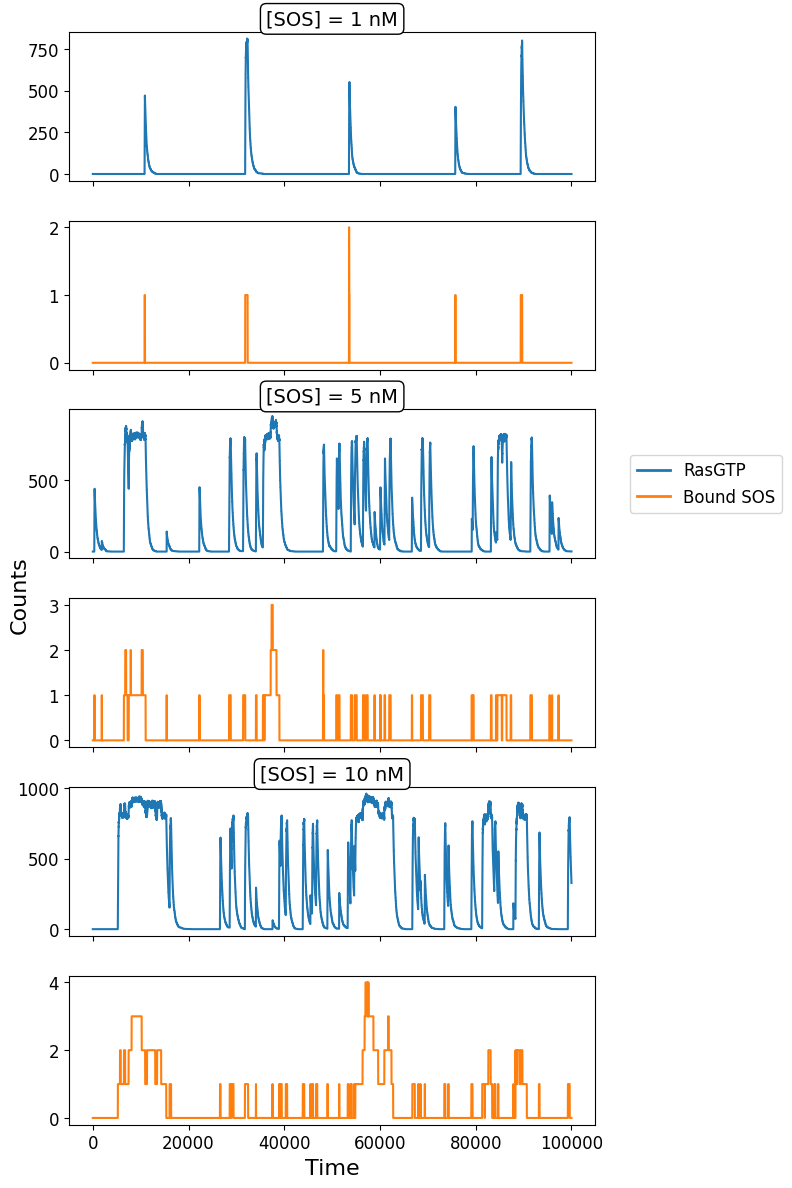

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

sos_values = [1, 5, 10] # [1,15,30] # to plot
indices = [i for i, val in enumerate(pval) if val in sos_values]
n_groups = len(indices)

obs = snames[:2]  
n_obs = len(obs)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


subplot_height = 1.76
intragroup_spacing = 0.1
intergroup_spacing = 0.55
total_height = n_groups * n_obs * subplot_height + (n_groups * (n_obs - 1)) * intragroup_spacing + (n_groups - 1) * intergroup_spacing

fig, axes = plt.subplots(n_groups * n_obs, 1, figsize=(8, total_height))
if n_groups * n_obs == 1:
    axes = [axes]

ax_idx = 0
for group_idx, idx in enumerate(indices):
    traj_i = traj[idx]
    time = traj_i['time']
    mask = time <= 100000
    time_trunc = time[mask]
    
    for j, ob in enumerate(obs):
        ax = axes[ax_idx]
        color = color_cycle[j % len(color_cycle)]
        
        ax.plot(time_trunc, traj_i[ob][mask], color=color)
        ax.tick_params(axis='both', labelsize=12)
        

        if j == 0:
            ax.text(0.5, 1.15, f"[SOS] = {pval[idx]} nM",
                   transform=ax.transAxes, ha='center', va='top', fontsize=14,
                   bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
        
        if not (group_idx == n_groups - 1 and j == n_obs - 1):
            ax.set_xticklabels([])
        
        ax_idx += 1
        

# Labels and legend
fig.text(0.01, 0.5, "Counts", va='center', rotation='vertical', fontsize=16)
axes[-1].set_xlabel("Time", fontsize=16)

handles = [
    Line2D([0], [0], color=color_cycle[0], lw=2, label="RasGTP"),
    Line2D([0], [0], color=color_cycle[1], lw=2, label="Bound SOS"),
]
mid_ax = axes[n_obs]
mid_ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.05, 0.5), 
             frameon=True, fontsize=12)


plt.tight_layout()
plt.show()

## Ras GTP distributions 

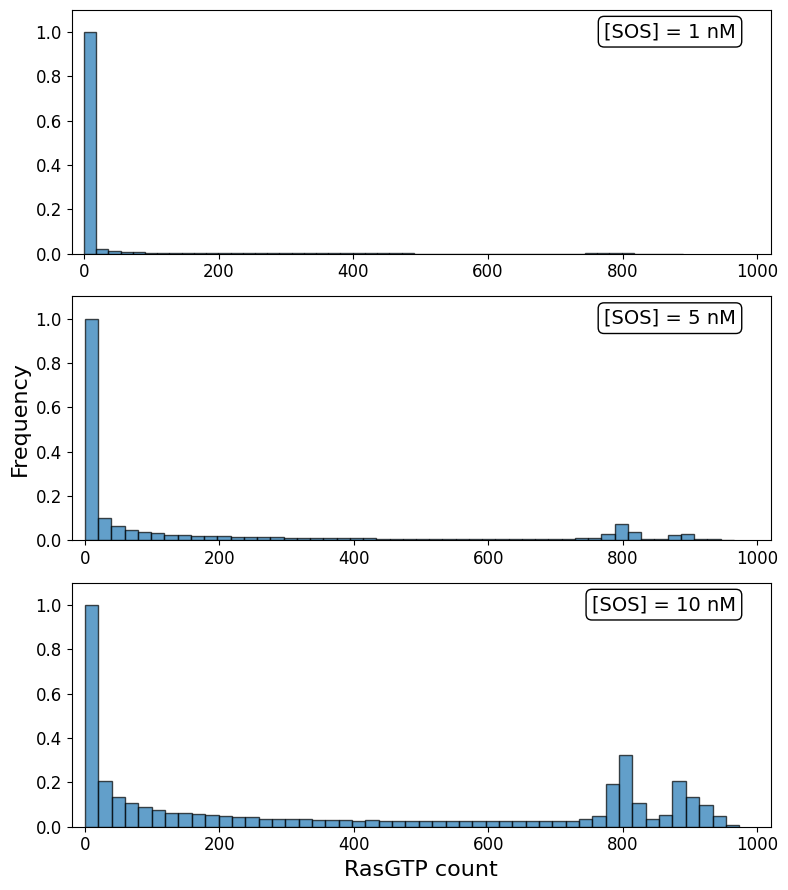

In [83]:
import matplotlib.pyplot as plt
import numpy as np

sos_values = [1, 5, 10]  # [1,15,30] # to plot
indices = [i for i, val in enumerate(pval) if val in sos_values]
n_groups = len(indices)

fig, axes = plt.subplots(n_groups, 1, figsize=(8, 3 * n_groups))
if n_groups == 1:
    axes = [axes]

for j, idx in enumerate(indices):
    ax = axes[j]
    ras_gtp = np.asarray(traj[idx]['totalRasGTP'])
    vmax = np.max(ras_gtp) if ras_gtp.size else 1
    bins = np.linspace(0, vmax, 50)
    
    counts, _ = np.histogram(ras_gtp, bins=bins)
    counts = counts / counts.max() if counts.max() > 0 else counts
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    ax.bar(bin_centers, counts, width=bins[1]-bins[0],
           edgecolor='black', alpha=0.7, color='C0', align='center')
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-bins[1], 1020)
    ax.tick_params(labelsize=12)
    
    ax.text(0.95, 0.95, f"[SOS] = {pval[idx]} nM",
           transform=ax.transAxes, ha='right', va='top', fontsize=14,
           bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    if j == n_groups - 1:
        ax.set_xlabel("RasGTP count", fontsize=16)
    if j == n_groups // 2:
        ax.set_ylabel("Frequency", fontsize=16)

plt.tight_layout()
plt.show()

## SOS Occupancy 

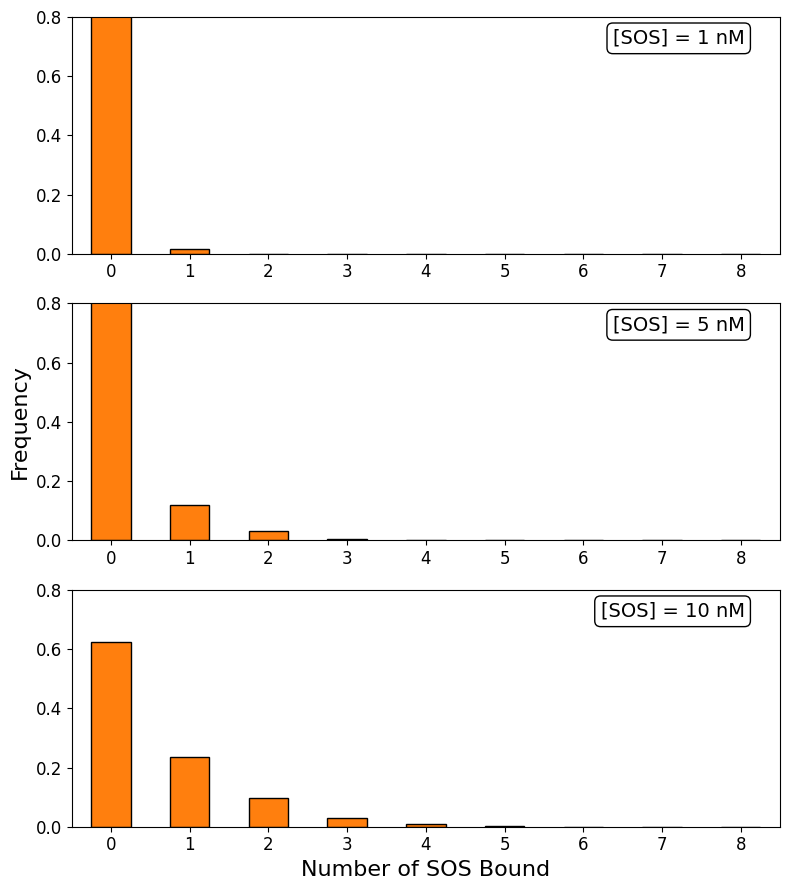

In [84]:
import matplotlib.pyplot as plt
import numpy as np

sos_values = [1, 5, 10] # [1,15,30] # to plot
indices = [i for i, val in enumerate(pval) if val in sos_values]
n_groups = len(indices)

fig, axes = plt.subplots(n_groups, 1, figsize=(8, 3 * n_groups))
if n_groups == 1:
    axes = [axes]

for j, idx in enumerate(indices):
    ax = axes[j]
    bound = 9
    width = 0.5
    bins_sos = np.arange(bound + 1) - 0.5 * width
    ax.hist(traj[idx]['totalBoundSOS'], bins=bins_sos, density=True, align='mid',
            width=width, color='C1', edgecolor='black')
    ax.set_xlim(-0.5, bound - 0.5)
    ax.set_ylim(0, 0.8)
    ax.tick_params(labelsize=12)
    
    ax.text(0.95, 0.95, f"[SOS] = {pval[idx]} nM",
           transform=ax.transAxes, ha='right', va='top', fontsize=14,
           bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    if j == n_groups - 1:
        ax.set_xlabel("Number of SOS Bound", fontsize=16)
    if j == n_groups // 2:
        ax.set_ylabel("Frequency", fontsize=16)

plt.tight_layout()
plt.show()

## Conditional Ras Distributions 

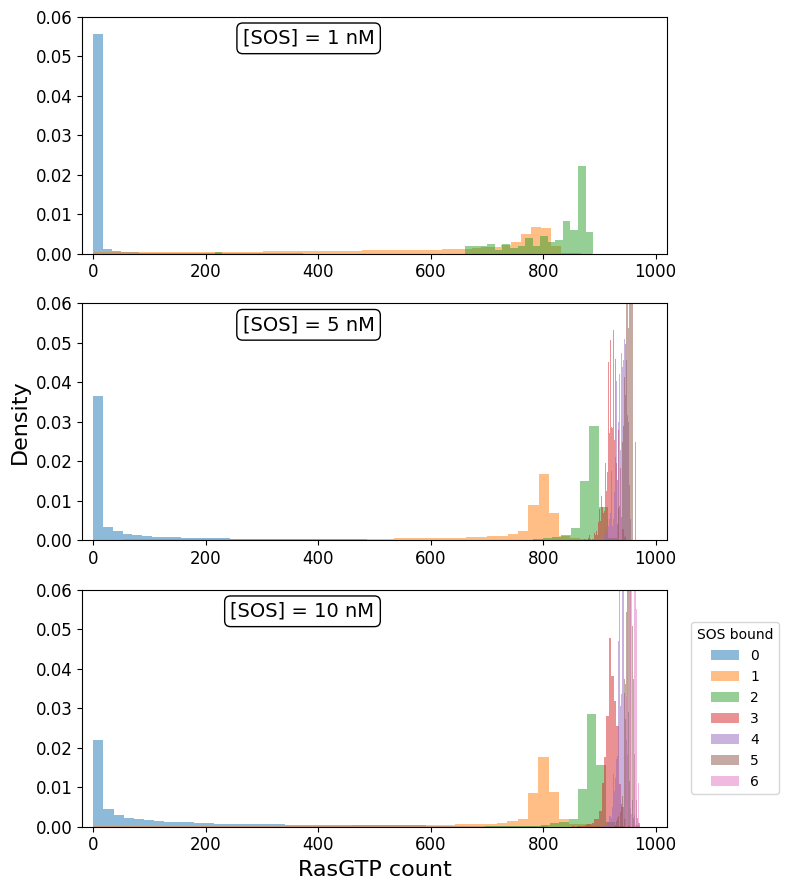

In [85]:
import matplotlib.pyplot as plt
import numpy as np

sos_values = [1, 5, 10] #[1,15,30] # values to plot 
indices_to_plot = [i for i, val in enumerate(pval) if val in sos_values]
n_groups = len(indices)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(n_groups, 1, figsize=(8, 3 * n_groups))
if n_groups == 1:
    axes = [axes]

for j, idx in enumerate(indices_to_plot):
    ax = axes[j]
    traj_i = traj[idx]
    global_smax = int(np.max(traj_i['totalBoundSOS']))
    
    for s in range(global_smax + 1):
        mask = (traj_i['totalBoundSOS'] == s)
        ras_gtp = np.asarray(traj_i['totalRasGTP'][mask])
        if ras_gtp.size > 0:
            ax.hist(ras_gtp, bins=50, density=True, alpha=0.5,
                   label=f'{s}', color=color_cycle[s % len(color_cycle)])
    
    ax.set_xlim(-20, 1020)
    ax.set_ylim(0, 0.06)
    ax.tick_params(labelsize=12)
    
    
    ax.text(0.5, 0.95, f"[SOS] = {pval[idx]} nM",
           transform=ax.transAxes, ha='right', va='top', fontsize=14,
           bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    if j == n_groups - 1:
        ax.set_xlabel("RasGTP count", fontsize=16)
    if j == n_groups // 2:
        ax.set_ylabel("Density", fontsize=16)

axes[-1].legend(title="SOS bound", fontsize=10, loc="center left", 
               bbox_to_anchor=(1.03, 0.5), frameon=True, title_fontsize=10)

plt.tight_layout()
plt.show()

## Activated Ras distributions 

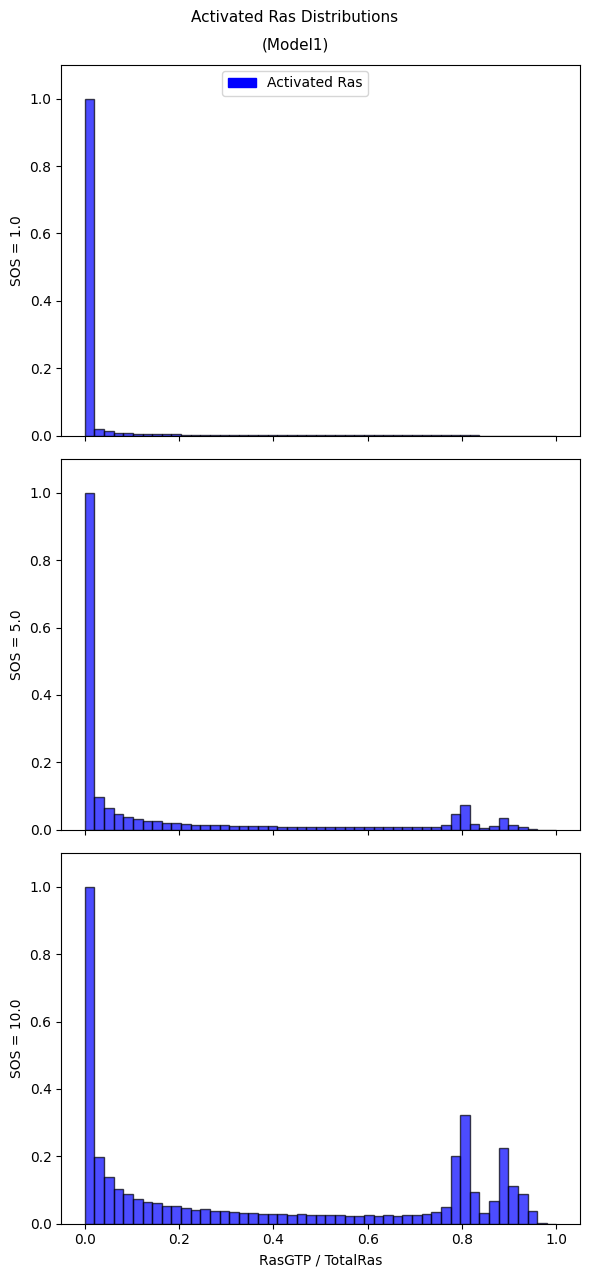

In [86]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True, figsize=(6, 14))
fig.subplots_adjust(top=0.4, hspace=0.4)

# Main title and subtitle
fig.text(0.5, 0.9, "Activated Ras Distributions", ha='center', fontsize=11)
fig.text(0.5, 0.88, f'({modelName})', ha='center', fontsize=11)

# subplots for RasGTP histograms only
for i in range(len(traj)):
    ax = axes[i]

    ras_gtp = traj[i][snames[0]]         # totalRasGTP
    total_ras = traj[i]['TotalRas']      

    # activated Ras ratio
    ras_ratio = ras_gtp / total_ras
    ras_ratio = ras_ratio[np.isfinite(ras_ratio)]

    #  histogram bins and compute counts
    bins = np.linspace(0, 1, 50)
    counts, _ = np.histogram(ras_ratio, bins=bins)
    counts = counts / counts.max() if counts.max() > 0 else counts

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_width = bins[1] - bins[0]

    ax.bar(bin_centers, counts, width=bin_width, edgecolor='black',
           alpha=0.7, color='blue', align='center')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel(f'SOS = {pval[i]:.1f}', color='black')

axes[-1].set_xlabel('RasGTP / TotalRas')


fig.legend([plt.Rectangle((0, 0), 1, 1, color='blue')],
           ['Activated Ras'], loc='upper center', ncol=1,
           bbox_to_anchor=(0.5, 0.87), fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()


## Plot RasGTP and Bound SOS Timecourse Trajectories 

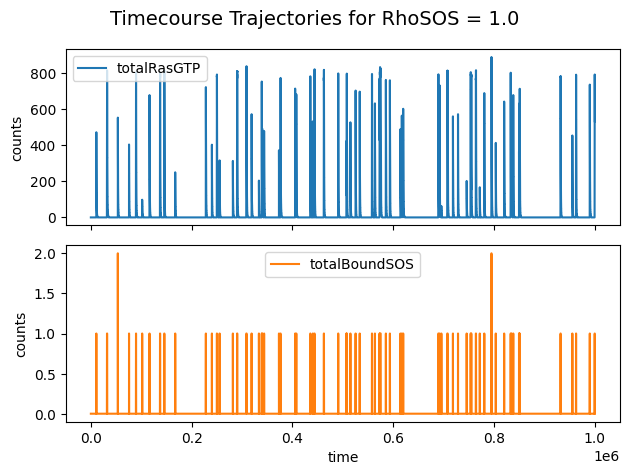

In [87]:
import matplotlib.pyplot as plt
import numpy as np

chosen_index = 0  # choose RhoSOS where 0 index = 1 nM initial SOS 
chosen_traj = traj[chosen_index]  
obs = snames[:2]
fig, axes = plt.subplots(nrows=len(obs), ncols=1, sharex=True)
axes = np.atleast_1d(axes)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

time_idx = chosen_traj.colnames.index('time')
time_data = chosen_traj[:, time_idx]

for i, ob in enumerate(obs):
    col_idx = chosen_traj.colnames.index(ob)  
    y_data = chosen_traj[:, col_idx]

    color = color_cycle[i % len(color_cycle)]
    axes[i].plot(time_data, y_data, label=ob, color=color)
    axes[i].set_ylabel('counts')
    axes[i].legend()

axes[-1].set_xlabel('time')
fig.suptitle(f'Timecourse Trajectories for RhoSOS = {pval[chosen_index]:.1f}', fontsize=14)
plt.tight_layout()
plt.show()


## Ras distribution conditioned on # of SOS bound

/var/folders/_d/lm0617153zx9hgvxqgrdb2lr0000gn/T/ipykernel_15543/305685067.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


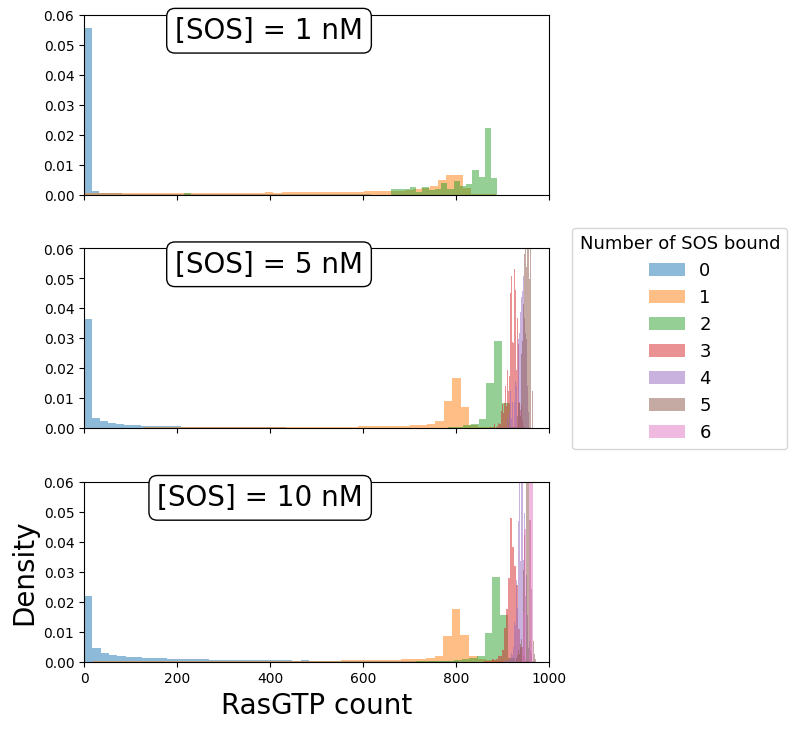

In [88]:
import matplotlib.pyplot as plt
import numpy as np

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# only 3 RhoSOS values
target_pvals = [1, 5, 10]
#target_pvals = [1, 15, 30]

#  match indices and values
available_indices = [i for i, val in enumerate(pval) if val in target_pvals]
available_pvals = [pval[i] for i in available_indices]
selected_traj = [traj[i] for i in available_indices]

# Global max for histogram separation
global_smax = int(max(np.max(t['totalBoundSOS']) for t in selected_traj))

# Create figure and axes
fig, axes = plt.subplots(
    nrows=len(selected_traj),
    ncols=1,
    figsize=(6, 2.8 * len(selected_traj)),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

# if single subplot
if len(selected_traj) == 1:
    axes = [axes]

# Plot histograms
for i, chosen_traj in enumerate(selected_traj):
    ax = axes[i]
    for s in range(global_smax + 1):
        mask = chosen_traj['totalBoundSOS'] == s
        ras_gtp = chosen_traj['totalRasGTP'][mask]
        if ras_gtp.size > 0:
            ax.hist(
                ras_gtp,
                bins=50,
                density=True,
                alpha=0.5,
                label=f'{s}',
                color=color_cycle[s % len(color_cycle)]
            )
    #ax.set_ylabel(f'[SOS]={available_pvals[i]} nM', fontsize=10, rotation=90, labelpad=20)
    ax.set_ylim(0, 0.06)
    ax.set_xlim(0, 1000)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.text(
        0.6, 0.99, f'[SOS] = {available_pvals[i]} nM',
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=20,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

# Legend
legend_handles, legend_labels = axes[-1].get_legend_handles_labels()
middle_ax = axes[len(axes) // 2]
middle_ax.legend(
    legend_handles,
    legend_labels,
    title='Number of SOS bound',
    fontsize=13,
    title_fontsize=13,
    bbox_to_anchor=(1.05, 0.5),  # Adjust position
    loc='center left',
    borderaxespad=0.
)


axes[-1].set_xlabel('RasGTP count', fontsize=20)
axes[-1].set_ylabel('Density', fontsize=20)
#fig.suptitle('RasGTP Density by Number of SOS Bound', fontsize=12, y=0.91)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Ras Activation 1-10nM initial SOS (new simulation)

1.0 7e-08
2.0 1.4e-07
3.0 2.1e-07
4.0 2.8e-07
5.0 3.5000000000000004e-07
6.0 4.2e-07
7.0 4.900000000000001e-07
8.0 5.6e-07
9.0 6.3e-07
10.0 7.000000000000001e-07


Text(0, 0.5, 'counts')

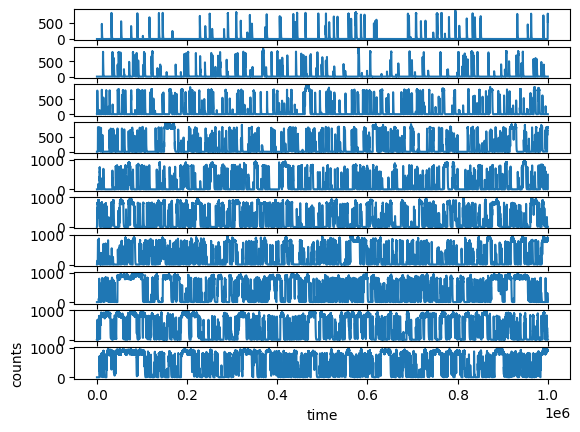

In [89]:
# simulation 

modelName = "Model1" #"Model2" "Model3"

model = bionetgen.bngmodel(modelName + ".bngl") 
sim = model.setup_simulator() 
sim.setIntegrator('gillespie')

snames=['totalRasGTP','totalBoundSOS','TotalRas'] # keep track of observables 
pval= np.linspace(1,10,10) # set range of RhoSOS 1 to 10 to iterate through 
traj=[0]*len(pval) 

Kon= 7e-8 # Model1 or 2
#Kon= 7e-5 # Model3 

for i, p in enumerate(pval):
    sim.RhoSOS= p
    
    sim.Kon1= p*Kon  # manually update Kon1 and Kon2 values 
    sim.Kon2= p*Kon 
    sim.reset()
    print(sim.RhoSOS,sim.Kon1)
    traj[i]= sim.simulate(0,1000000,1000000)

# plot trajectories
fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True) #, figsize=(4, 12))
for i in range(len(traj)):
    axes[i].plot(traj[i]['time'],traj[i][snames[0]])
axes[-1].set_xlabel('time')
axes[-1].set_ylabel('counts')
#plt.tight_layout()




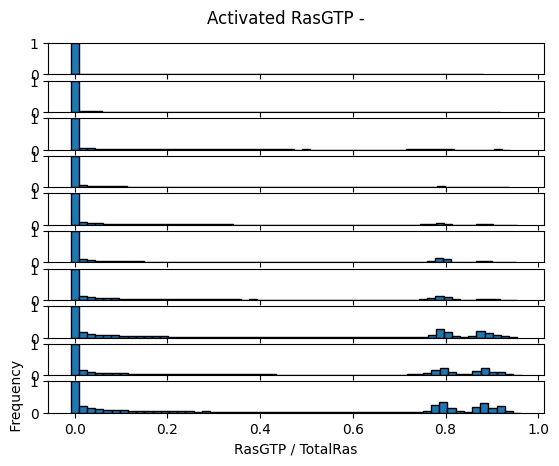

In [90]:
# plot Activated RasGTP  as ratio of totalRasGTP/totalRas 

fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True)

for i in range(len(traj)):
    total_ras_gtp = traj[i][snames[0]]  # 'totalRasGTP'
    total_ras = traj[i][snames[2]]      # 'TotalRas'
    activated_ras_gtp = total_ras_gtp / total_ras  


    n, bins = np.histogram(activated_ras_gtp, bins=55)
    
    # normalize so max height is 1
    normalized_values = n / np.max(n)  
    
    bar_width = np.diff(bins)

    axes[i].bar(bins[:-1], normalized_values, width=bar_width, edgecolor='black')
    axes[i].set_ylim(0, 1)  


axes[-1].set_xlabel('RasGTP / TotalRas')
axes[-1].set_ylabel(' Frequency')
fig.suptitle("Activated RasGTP - ", fontsize=12, y=0.95)

plt.show()

Text(0.5, 0.95, 'SOS ')

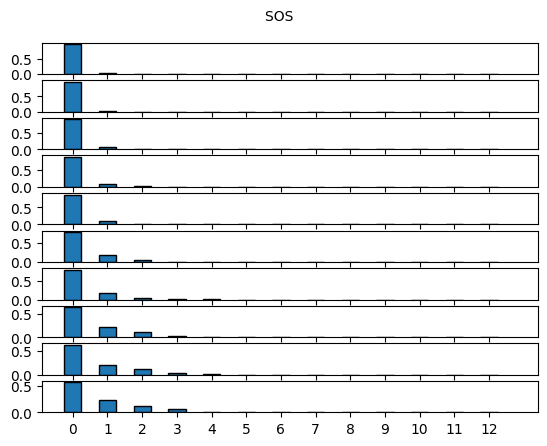

In [91]:
# bound SOS occupancy distributions

fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True) #, figsize=(4, 12))


bound = 13
width = 0.5  # adjusted width for  centering
area_value = 1


bins = np.arange(bound + 1) - 0.5 * width  

for i in range(len(traj)):
    s= snames[1]
    axes[i].hist(traj[i][s], bins=bins, density=True, align='mid', width=width, edgecolor='black')
    
    #axes[i - 1].set_ylim(0, 0.8)
    axes[i].set_xticks(np.arange(0, bound, 1))
    axes[i].set_yticks(np.arange(0, 1, 0.5))
fig.suptitle("SOS ", fontsize=10, y=0.95)


/var/folders/_d/lm0617153zx9hgvxqgrdb2lr0000gn/T/ipykernel_15543/107258258.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


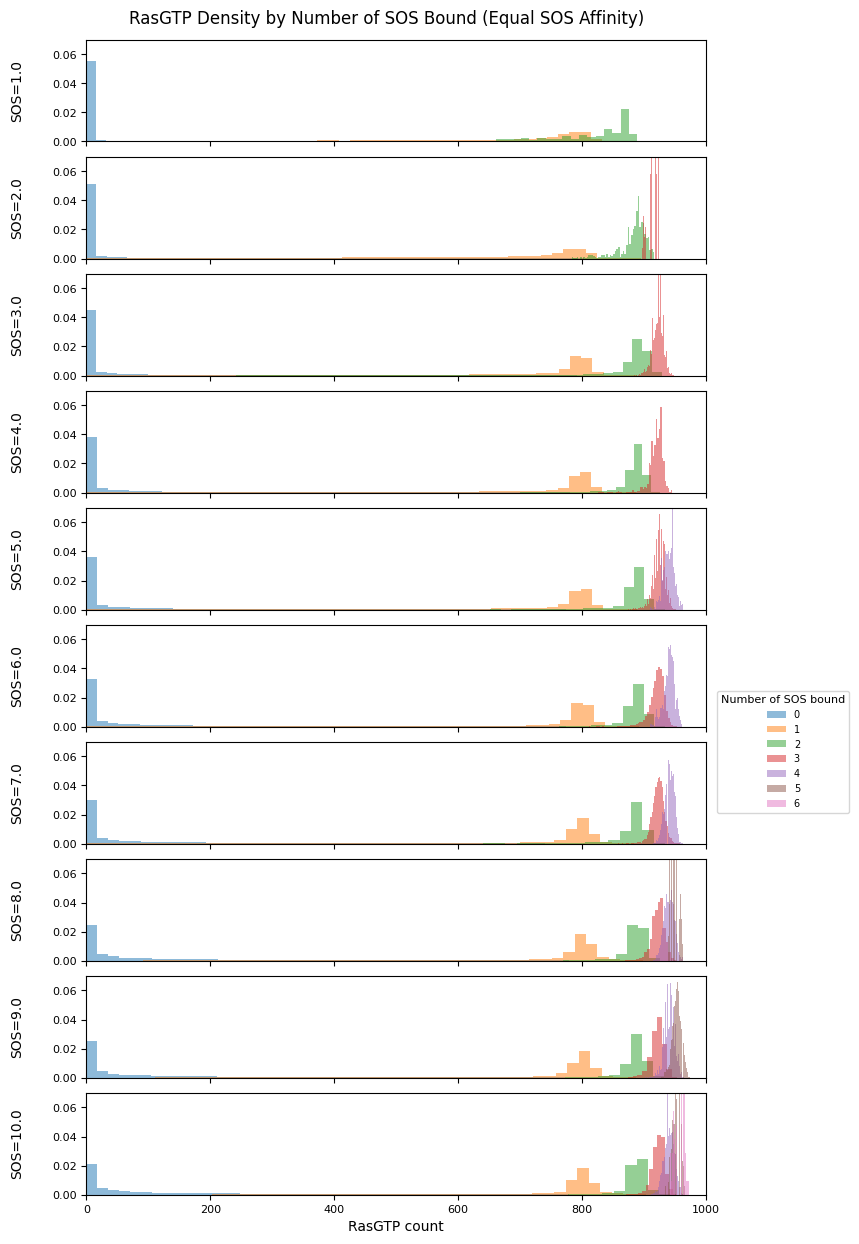

In [92]:
# conditional SOS distributions 

import matplotlib.pyplot as plt
import numpy as np


color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


global_smax = int(max(np.max(t['totalBoundSOS']) for t in traj))


fig, axes = plt.subplots(
    nrows=len(pval), ncols=1,
    figsize=(8, 1.5 * len(pval)),
    sharex=True,
    gridspec_kw={'hspace': 0.15}
)

# plot each subplot
for i, chosen_traj in enumerate(traj):
    ax = axes[i]

    #  histograms for each SOS bound level
    for s in range(global_smax + 1): 
        mask = chosen_traj['totalBoundSOS'] == s
        ras_gtp = chosen_traj['totalRasGTP'][mask]
        if ras_gtp.size > 0:
            ax.hist(
                ras_gtp,
                bins=50,
                density=True,
                alpha=0.5,
                label=f'{s}',
                color=color_cycle[s % len(color_cycle)]
            )

    ax.set_ylabel(f'SOS={pval[i]}', rotation=90, labelpad=20, fontsize=10)
    ax.set_ylim(0, 0.07)
    ax.set_xlim(0, 1000)
    ax.tick_params(axis='both', which='major', labelsize=8)

last_ax = axes[-1]  # last subplot
middle_ax = axes[len(pval) // 2]  #middle subplot

# Add legend based on the last subplot
last_ax.legend(
    title='Number of SOS bound',
    fontsize=7,
    title_fontsize=8,
    bbox_to_anchor=(1.01, 5),
    loc='upper left'
)

# Final labels and title
axes[-1].set_xlabel('RasGTP count', fontsize=10)
fig.suptitle('RasGTP Density by Number of SOS Bound (Equal SOS Affinity)', fontsize=12, y=0.9)

# Adjust layout so the legend is placed correctly next to the middle subplot
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()


## Bifurcation Plot 

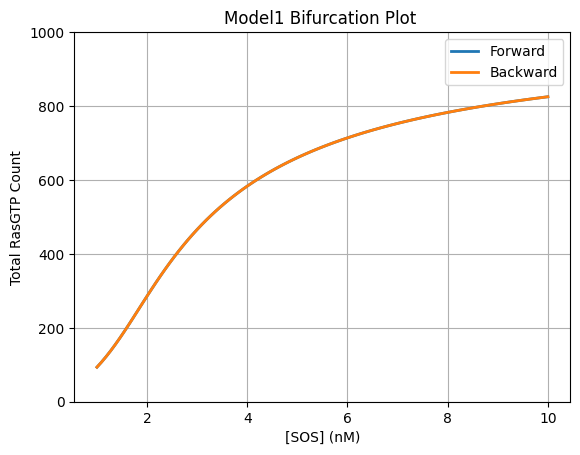

In [93]:
# bifurcation plot 


import numpy as np
import matplotlib.pyplot as plt
import bionetgen


# load and prepare model
model = "Model1"
modelName = "Model1" 
#model = "Model2"
#model = "Model3"

model = bionetgen.bngmodel(model + ".bngl")
sim = model.setup_simulator()
sim.setIntegrator('cvode')  #  deterministic ODE solver


snames = ['totalRasGTP', 'totalBoundSOS', 'TotalRas']
sim.selections = snames
Kon=7e-8
#Kon=7e-5

#  parameter range
pval_forward = np.linspace(1, 10, 100)
pval_backward = pval_forward[::-1]



#  results
ras_fwd = []
ras_bwd = []

# forward 

# for 100 values between 1 and 10, simulating 1,000,000 timestep simulation and recording final RasGTP value
for p in pval_forward:
    sim.RhoSOS = p
    sim.Kon1 = p * Kon
    sim.Kon2 = p * Kon
    sim.reset()
    result = sim.simulate(0, 1000000, 2)
    ras_fwd.append(result[-1, 0])

# backward 
for p in pval_backward:
    sim.RhoSOS = p
    sim.Kon1 = p * Kon
    sim.Kon2 = p * Kon
    sim.reset()
    result = sim.simulate(0, 1000000, 2)
    ras_bwd.append(result[-1, 0])

# Plotting
plt.plot(pval_forward, ras_fwd, label='Forward', color='C0', linewidth=2)
plt.plot(pval_backward, ras_bwd, label='Backward', color='C1', linewidth=2)

plt.xlabel('[SOS] (nM)')
plt.ylabel('Total RasGTP Count')
#plt.title('Multimodal Bifurcation Plot')
plt.title(f'{modelName} Bifurcation Plot ')#, #weight='bold')
plt.ylim(0, 1000)
plt.legend()
plt.grid(True)
plt.show()

